# Table of Contents

- [Goal](#Goal)
- [Wrangle](#Wrangle)
- [Explore Data Analysis (EDA)](#EDA)
  - [Gender](#Gender)
  - [Visualizations](#Visualizations)
  - [Insightful](#Insightful-Visualizations)
  - [Hypothesis Testing](#Hypothesis-Testing)
- [Modeling](#Modeling)
- [Results and Conclusions](#Results-and-Conclusions)
  - [Next Steps](#Next-Steps)
- [Appendix](#Appendix)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import scipy.stats as stats
from wranglev2 import wrangle_credit

import warnings
warnings.filterwarnings("ignore")
print('Initialized')

Initialized


# Goal

Chinese banks are very risk-averse, yet younger generations are more willing to take on debt at similar rates to other developed countries. What are the contributing factors to a credit card holder defaulting on debt? When will an account default 6 months into the future? That is what we aim to find out! We will accomplish this by looking for patterns in a user's credit history and application data, always with an eye to ethical consideration when dealing with demographic data, to predict if they will default 6 months in the future. 

**Bottom Line Up Front (BLUF)**

From all the work contained in this notebook we have deteremined that...

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Wrangle

All the prep/wrangle work is handled by the wrangle_credit function imported above. For an indpeth explination of how the wrangle_credit function works please see the [How-To Notebook](https://github.com/credit-risk-management-predictor/credit-risk-management-predictor/blob/main/how_to.ipynb).


In [2]:
help(wrangle_credit)

Help on function wrangle_credit in module wranglev2:

wrangle_credit()
    This function does the following:
    * uses get_reports_data function to process credit_reports.csv data into the expanded DF 
    * uses get_application_data functionto process the application_record.csv into an apps DF
    * uses encode_dummies function to create dummy variables from the categorical variables of the apps DF
    * merges the apps and expanded DFs into a final_df on 'id'
    * uses split_stratify_data on the final_df to create the train, validate, test data sets
    * return train, validate, test data sets as DFs
    Note - The create_scaled_x_y function will be used after EDA to avoid confusion.
    Note 2 - Remember to drop columns not used as features such as age, gender, etc



In [3]:
train, validate, test = wrangle_credit()
train.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,first_half_score,difference_score,odds_evens_score,begining_score,middle_score,ending_score,spread_score,alpha_omgea_score,begining_ending_score,defaulted
22151,5142128,F,0,0,0,283500.0,Commercial associate,Secondary / secondary special,Married,Municipal apartment,...,0,0,0,0,0,0,0,0,0,0
21572,5136981,F,0,0,0,306000.0,State servant,Higher education,Married,House / apartment,...,7,-2,9,4,6,2,9,3,6,0
8328,5052719,F,0,0,0,126000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,3,0,4,2,2,2,4,2,4,0
19787,5117901,F,0,0,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,3,0,4,2,2,2,4,2,4,0
12424,5069147,M,0,1,0,216000.0,Commercial associate,Higher education,Married,House / apartment,...,2,-1,3,2,0,1,0,3,3,0


**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# EDA

When dealing with something as consequential as credit card approvals, it is important to make sure you aren't training your model with data that has been biased against a demographic class due to historical discrimination as this can reinforce cultural biases. Besides, it's also bad for business. Knowing this, we will begin by determining if ***gender*** can be inferred from other information within the application data. 

After we explore if gender can be inferred from other information, we will then explore the rest of the data by visualizing it. We will then conduct [hypothesis testing](#Hypothesis-Testing) on any [insightful visualization](#Insightful-Visualizations)  in order to determine which to use in modeling.

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Gender

In order to determine whether or not gender can be inferred from our data we have to conduct hypothesis tests. We will cross reference gender with the following features:

> flag_own_car, flag_own_realty, cnt_children, amt_income_total, name_income_type

We accomplished this by running Two-Sample; Two-Tail T-tests and found that each had a significant statistically relationship with gender. However, while income and gender have a relationship, gender and income may suffer from a third variable problem.  Intuitively, this makes sense as income is also greatly dependent upon occupation. A T-test would show the macro relationship between gender and income, but would not be able to account for other confounding factors. For more details on the gender pay gap, see [The True Story of the Gender Pay Gap](https://freakonomics.com/podcast/the-true-story-of-the-gender-pay-gap-a-new-freakonomics-radio-podcast/) & [What Can Uber Teach Us About the Gender Pay Gap](https://freakonomics.com/podcast/what-can-uber-teach-us-about-the-gender-pay-gap/) both by [Feakonomics Podcast](www.freakonomics.com).

Next, we continue on with our EDA by exploring [other variables](#Visualizations) relationship with 'defaulted.'

---
**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [4]:
train.code_gender.value_counts()

F    11730
M     5903
Name: code_gender, dtype: int64

Text(0.5, 0, 'Number of Applicants')

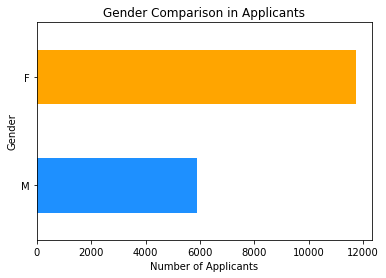

In [5]:
train.code_gender.value_counts().sort_values().plot(kind = 'barh', color = ['dodgerblue', 'orange'])
plt.title('Gender Comparison in Applicants')
plt.ylabel('Gender')
plt.xlabel('Number of Applicants')

### What are the average default rates between men and women**

In [6]:
# Average default rate amongst males
men = train[train.code_gender == 'M'].defaulted.mean()

# Average default rate amongst females
women = train[train.code_gender == 'F'].defaulted.mean()

print(f"The average default for men is {round(men, 4)}. \nThe average default rate for women is {round(women, 4)}")

The average default for men is 0.0042. 
The average default rate for women is 0.0034


### Is there a relationship between gender and car ownership?

In [7]:
# Average car ownership amongst males
men = train[train.code_gender == 'M'].flag_own_car.mean()

# Average car ownership amongst females
women = train[train.code_gender == 'F'].flag_own_car.mean()

print(f"The average car ownership for men is {round(men, 4)}. \nThe average default rate for women is {round(women, 4)}")



The average car ownership for men is 0.651. 
The average default rate for women is 0.2596


In [8]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].flag_own_car, train[train.code_gender == 'F'].flag_own_car)

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males own cars at a higher rate than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, males own cars at a higher rate than females.


### Is there a relationship between gender and realty ownership?

In [9]:
# Average home ownership amongst males
men = train[train.code_gender == 'M'].flag_own_realty.mean()

# Average home ownership amongst females
women = train[train.code_gender == 'F'].flag_own_realty.mean()

print(f"The average realty ownership rate for men is {round(men, 4)}. \nThe average realty ownership rate for women is {round(women, 4)}")

The average realty ownership rate for men is 0.6143. 
The average realty ownership rate for women is 0.6738


Males appear to own cars at a higher rate than females. We can validate this observation with a t-test:

$H_0$: There is no difference in car ownership rates among males and females.  
$H_0$: There is a difference in car ownership rates among males and females.

In [10]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].flag_own_car, train[train.code_gender == 'F'].flag_own_car)
stat, p

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males have more children than females.')
else:
    print('We fail to reject the null hypothesis.')   

We reject the null hypothesis. Based on t-statistic, males have more children than females.


### Is there a relationship between gender and the number of children?

In [11]:
# Average number of children amongst males
men = train[train.code_gender == 'M'].cnt_children.mean()

# Average number of children amongst females
women = train[train.code_gender == 'F'].cnt_children.mean()

print(f"The average number of children for men is {round(men, 2)}. \nThe average number of children for women is {round(women, 2)}")

The average number of children for men is 0.53. 
The average number of children for women is 0.38


Male applicants appear to have more children than female applicants. We can validate this with a t-test:

$H_0$: There is no difference in the number of children between males and females  
$H_a$: There is a difference in the number of children between males and females

In [12]:
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].cnt_children, train[train.code_gender == 'F'].cnt_children)
stat, p

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, men have more children than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, men have more children than females.


### Is there a relationship between gender and income?

In [13]:
# Average income amongst males
men = train[train.code_gender == 'M'].amt_income_total.mean()

# Average income amongst females
women = train[train.code_gender == 'F'].amt_income_total.mean()

print(f"The average income for men is {round(men, 2)}. \nThe average income for women is {round(women, 2)}")

The average income for men is 219159.84. 
The average income for women is 173498.37


Male applicants appear to have more higher incomes than female applicants. We can validate this with a t-test:

$H_0$: There is no in income between males and females  
$H_a$: There is a difference in income between males and females

In [14]:
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].amt_income_total, train[train.code_gender == 'F'].amt_income_total)

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males have more income than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, males have more income than females.


### Is there a relationship between gender and income type?

In [15]:
# Create a crosstab of gender and income type
gender_income_type = pd.crosstab(train.code_gender, train.name_income_type)

# Visualize intial crosstab
gender_income_type

name_income_type,Commercial associate,Pensioner,State servant,Student,Working
code_gender,,,,,
F,2734,2423,1109,8,5456
M,1472,422,421,0,3588


In [16]:
# Convert counts to percentages by column
gender_income_type['Commercial associate'] = (gender_income_type['Commercial associate'] / gender_income_type['Commercial associate'].sum() * 100)
gender_income_type['Pensioner'] = (gender_income_type['Pensioner'] / gender_income_type['Pensioner'].sum() * 100)
gender_income_type['State servant'] = (gender_income_type['State servant'] / gender_income_type['State servant'].sum() * 100)
gender_income_type['Student'] = (gender_income_type['Student'] / gender_income_type['Student'].sum() * 100)
gender_income_type['Working'] = (gender_income_type['Working'] / gender_income_type['Working'].sum() * 100)

# Visualize modified crosstab
gender_income_type

name_income_type,Commercial associate,Pensioner,State servant,Student,Working
code_gender,,,,,
F,65.002378,85.16696,72.48366,100.0,60.327289
M,34.997622,14.83304,27.51634,0.0,39.672711


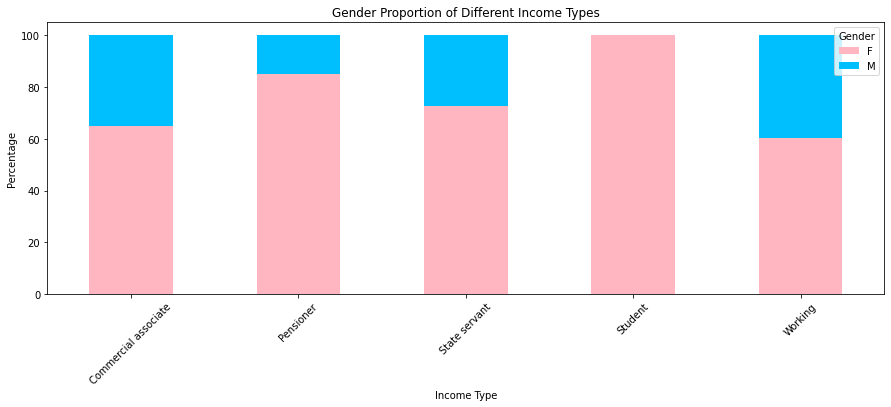

In [17]:
# Visualize percentages as stacked bar for each gender
gender_income_type[['Commercial associate', 'Pensioner', 'State servant', 'Student', 'Working']].T.plot(kind='bar', stacked=True, color = ['lightpink', 'deepskyblue'], figsize=(15,5))

# Add title text
plt.title('Gender Proportion of Different Income Types')

# Add y-axis label
plt.ylabel('Percentage')

# Change orientation of x-tick labels for easier reading
plt.xticks(rotation=45)

# Add x-axis label
plt.xlabel('Income Type')

# Clarify label title
plt.legend(title='Gender')

# Show chart
plt.show()

In [18]:
# Create a crosstab of gender and income type
gender_income_type = pd.crosstab(train.code_gender, train.name_income_type) 

# Create a new column that is the sum of each row
gender_income_type.loc[:,'Total'] = gender_income_type.sum(axis=1) 

# Convert quantities into percentages by row
gender_income_type['Commercial associate'] = (gender_income_type['Commercial associate'] / gender_income_type['Total'] * 100)
gender_income_type['Pensioner'] = (gender_income_type['Pensioner'] / gender_income_type['Total'] * 100)
gender_income_type['State servant'] = (gender_income_type['State servant'] / gender_income_type['Total'] * 100)
gender_income_type['Student'] = (gender_income_type['Student'] / gender_income_type['Total'] * 100)
gender_income_type['Working'] = (gender_income_type['Working'] / gender_income_type['Total'] * 100)

# View the dataframe
gender_income_type

name_income_type,Commercial associate,Pensioner,State servant,Student,Working,Total
code_gender,,,,,,
F,23.307758,20.656436,9.454390,0.068201,46.513214,11730
M,24.936473,7.148907,7.131967,0.000000,60.782653,5903


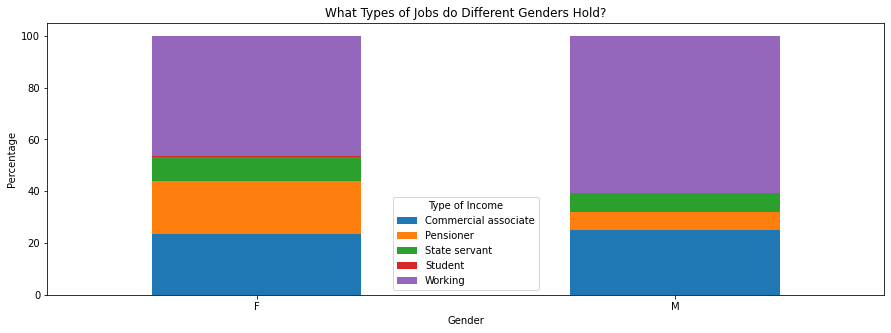

In [19]:
# Visualize percentages as stacked bar for each gender
gender_income_type[['Commercial associate', 'Pensioner', 'State servant', 'Student', 'Working']].plot(kind='bar', stacked=True, figsize=(15,5))

# Add title text
plt.title('What Types of Jobs do Different Genders Hold?')

# Add y-axis label
plt.ylabel('Percentage')

# Change orientation of x-tick labels for easier reading
plt.xticks(rotation=0)

# Add x-axis label
plt.xlabel('Gender')

# Clarify label title
plt.legend(title='Type of Income')

# Show chart
plt.show()

In [20]:
gender_income_type_pensioner_working = pd.crosstab(train.code_gender, train.name_income_type)[['Pensioner', 'Working']]
gender_income_type_pensioner_working

name_income_type,Pensioner,Working
code_gender,,
F,2423,5456
M,422,3588


## Visualizations

Our traget variable and many of our features are catagorical variables. As such, we will focus our visulization efforts on the score features we synthizied from monthly status. We will do this by creating strip and violin plot pairs to see the distribution of the data. 

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [21]:
train.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members', 'employed_years',
       'age', 'name_income_type_commercial_associate',
       'name_income_type_pensioner', 'name_income_type_state_servant',
       'name_income_type_student', 'name_income_type_working',
       'name_education_type_academic_degree',
       'name_education_type_higher_education',
       'name_education_type_incomplete_higher',
       'name_education_type_lower_secondary',
       'name_education_type_secondary_/_secondary_special',
       'name_housing_type_co-op_apartment',
       'name_housing_type_house_/_apartment',
       'name_housing_type_municipal_apartment',
       'name_housing_type_office_apartment',
       'name_housing

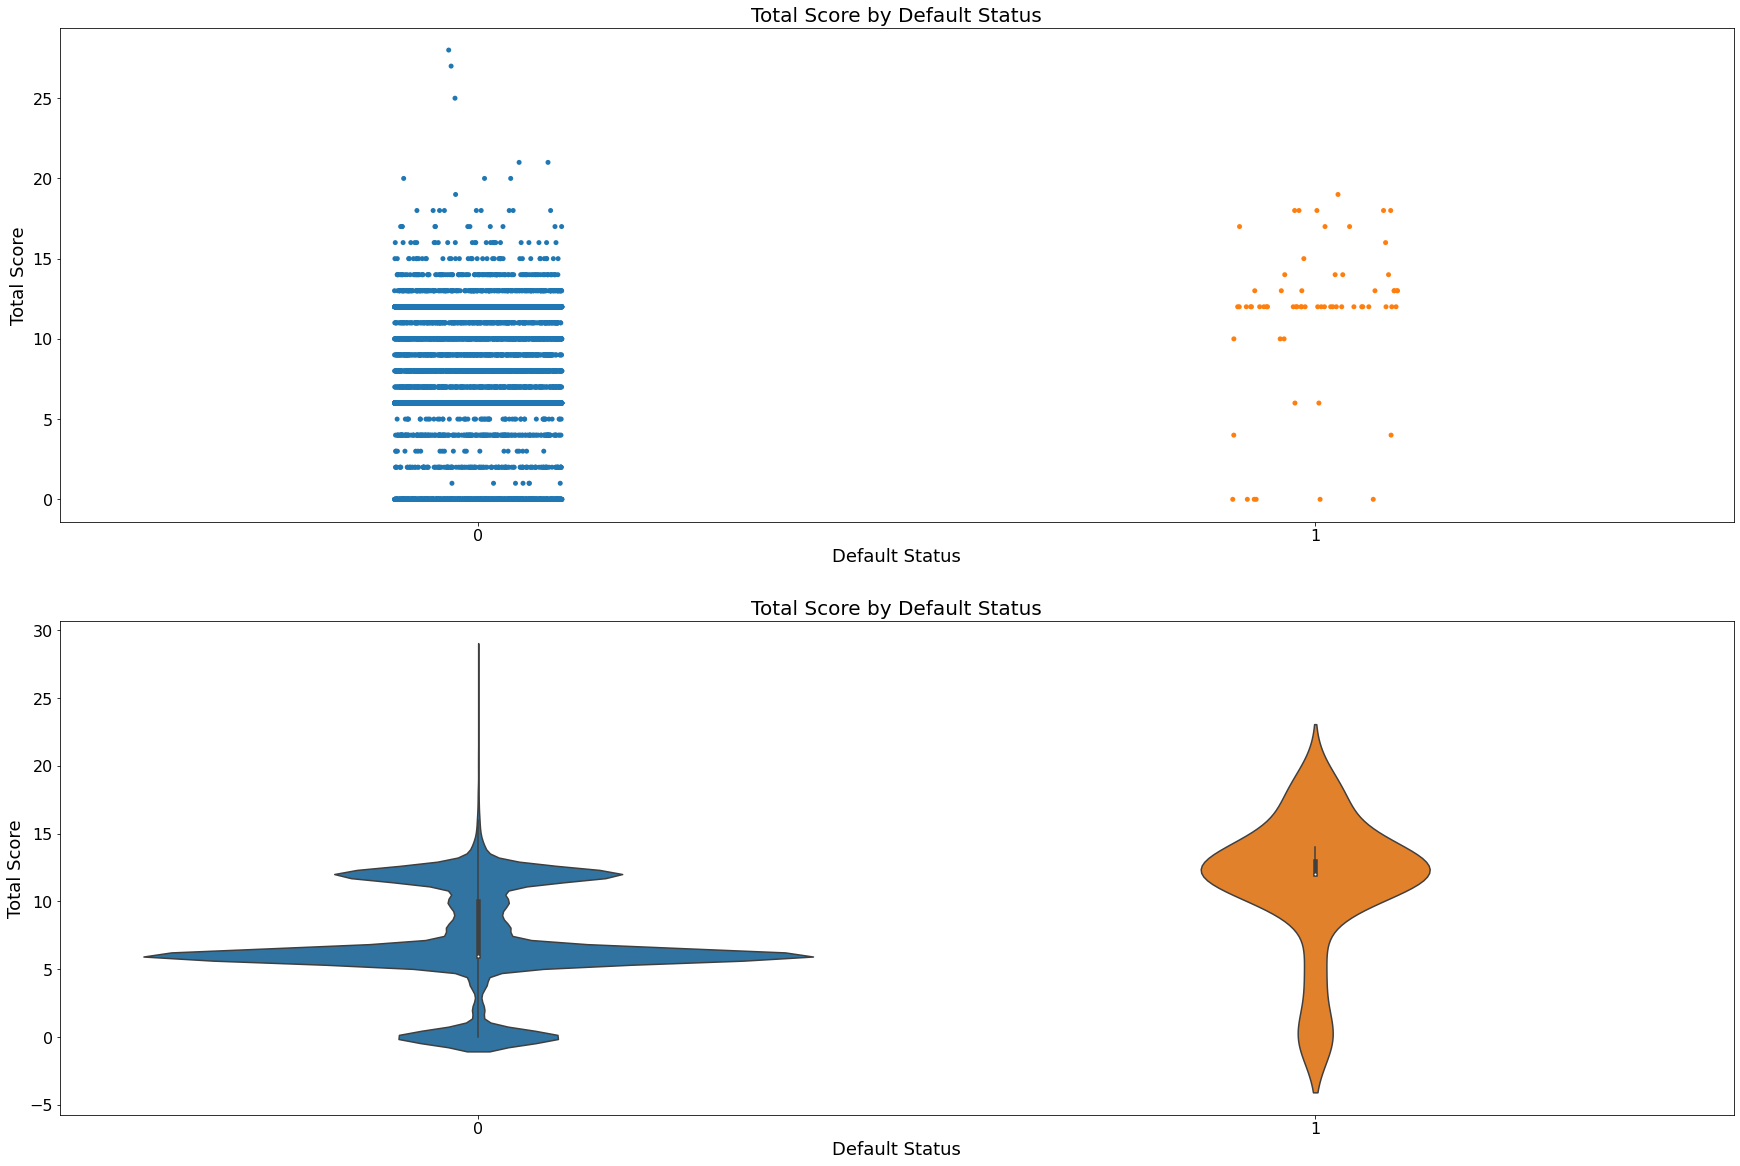

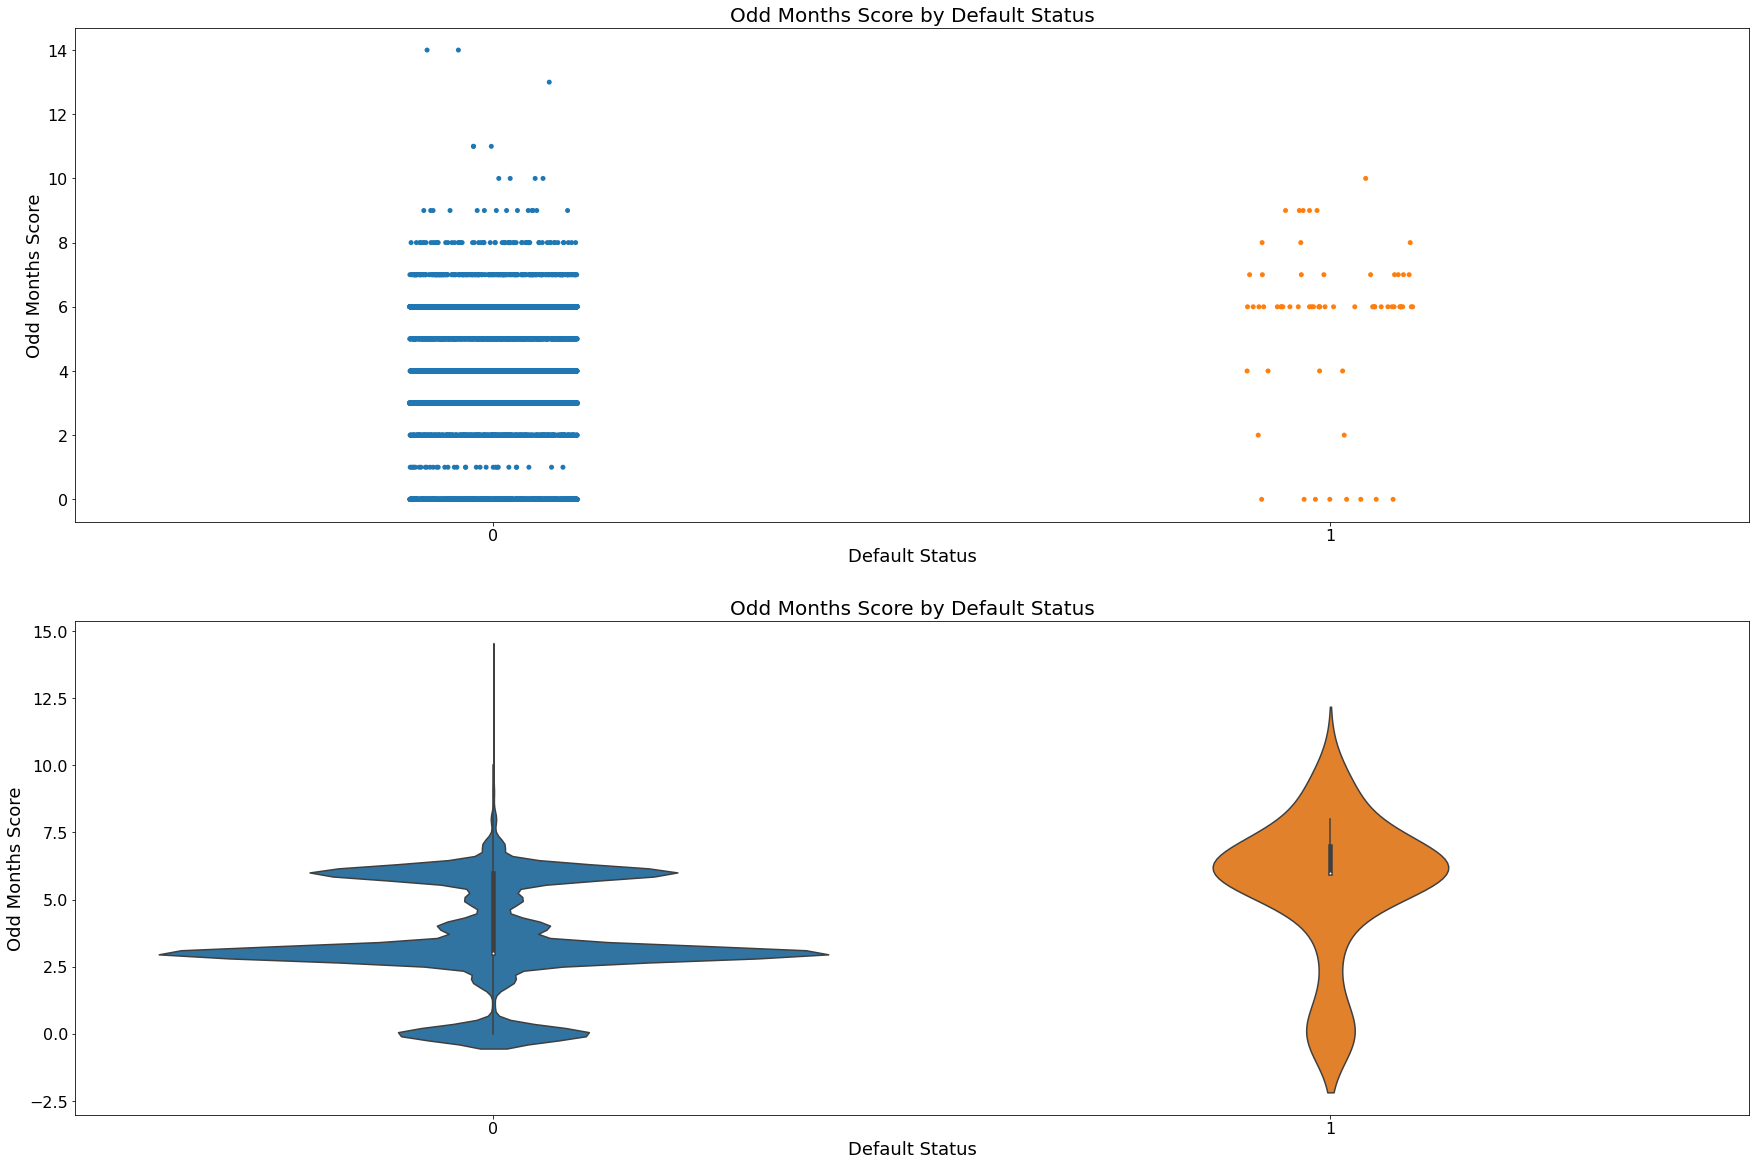

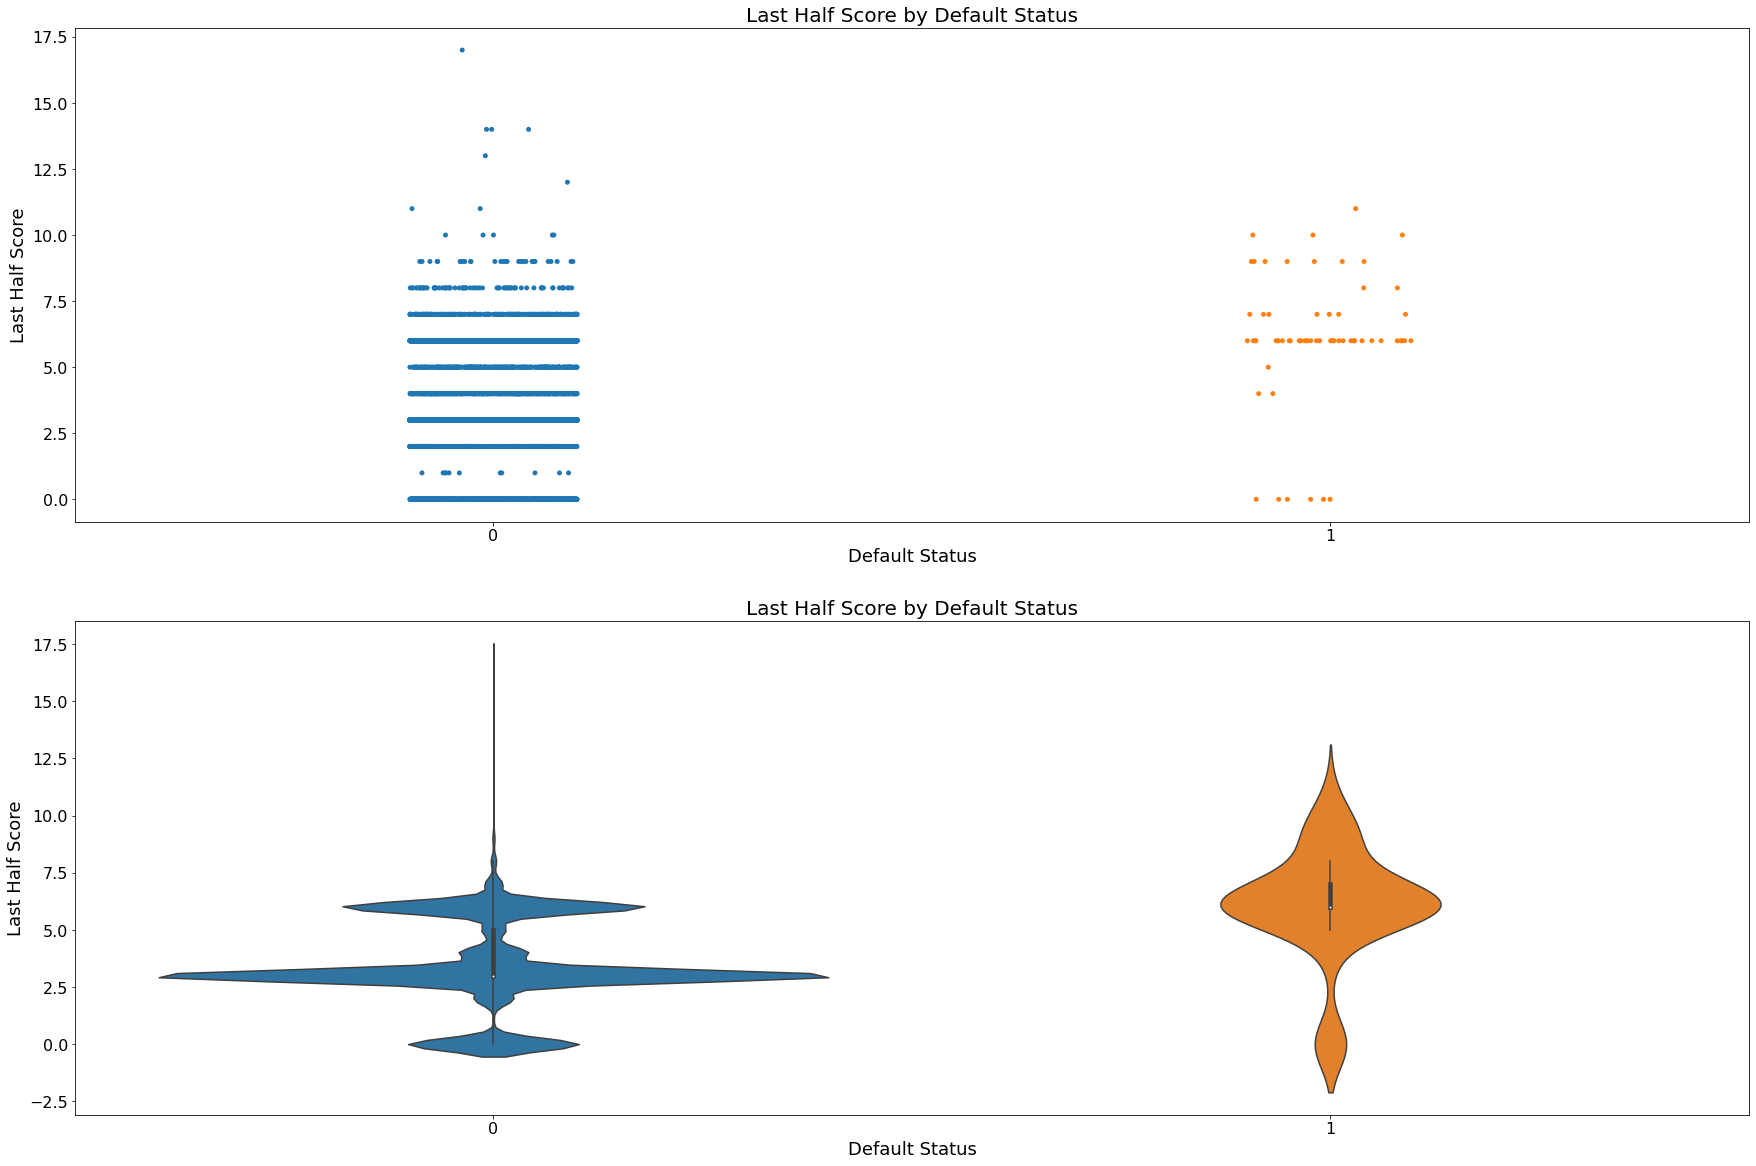

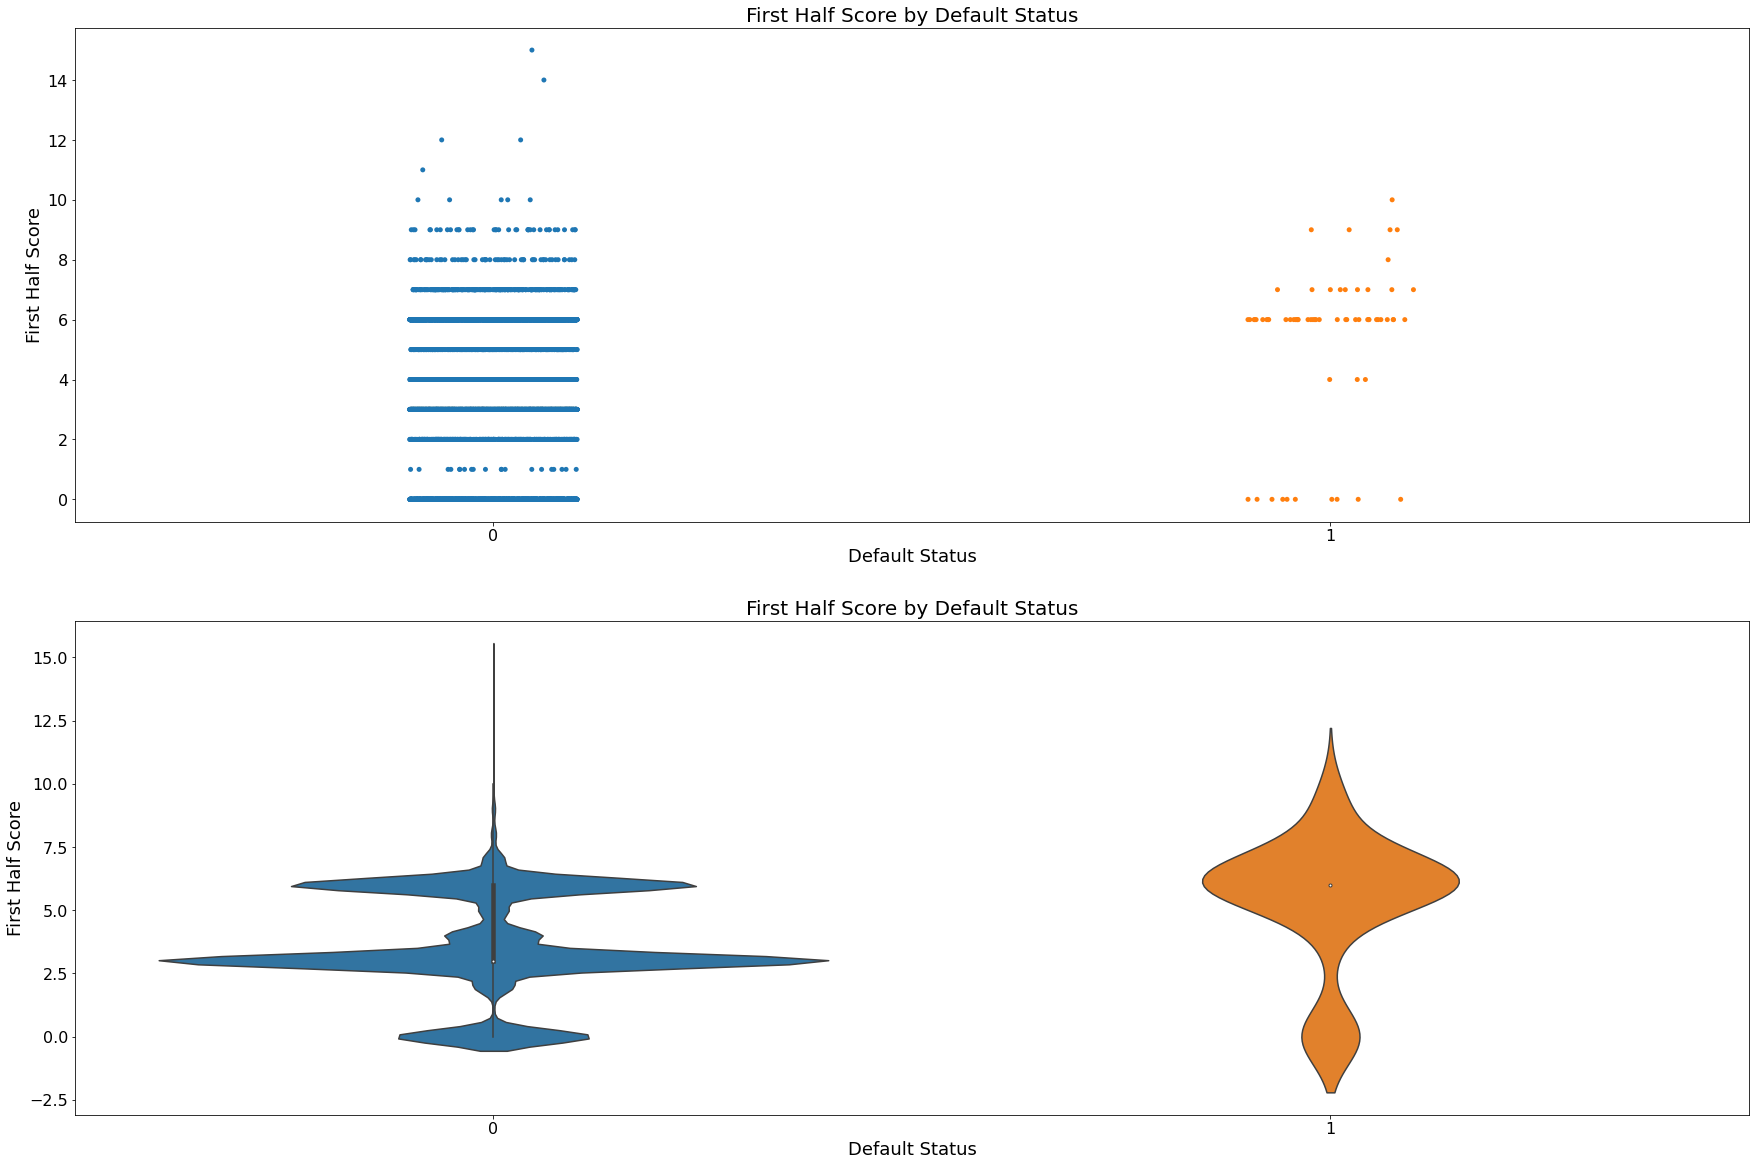

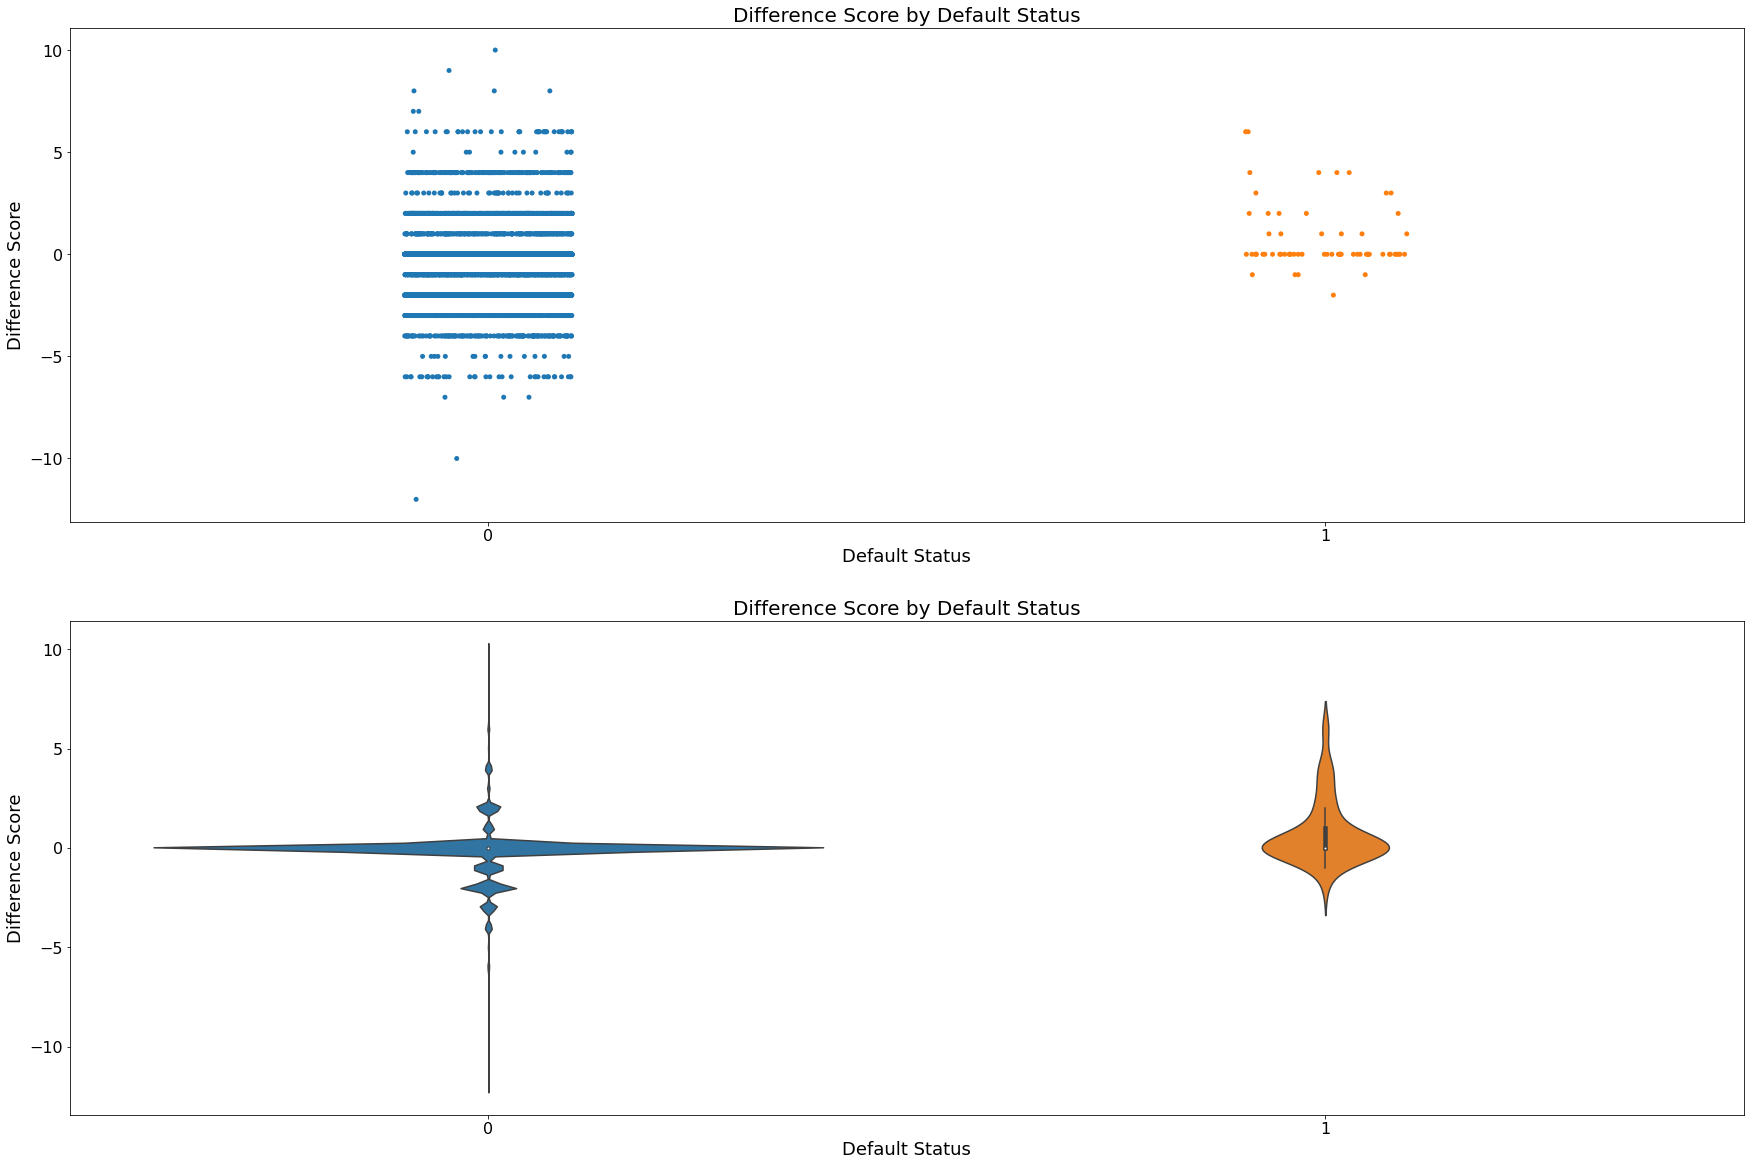

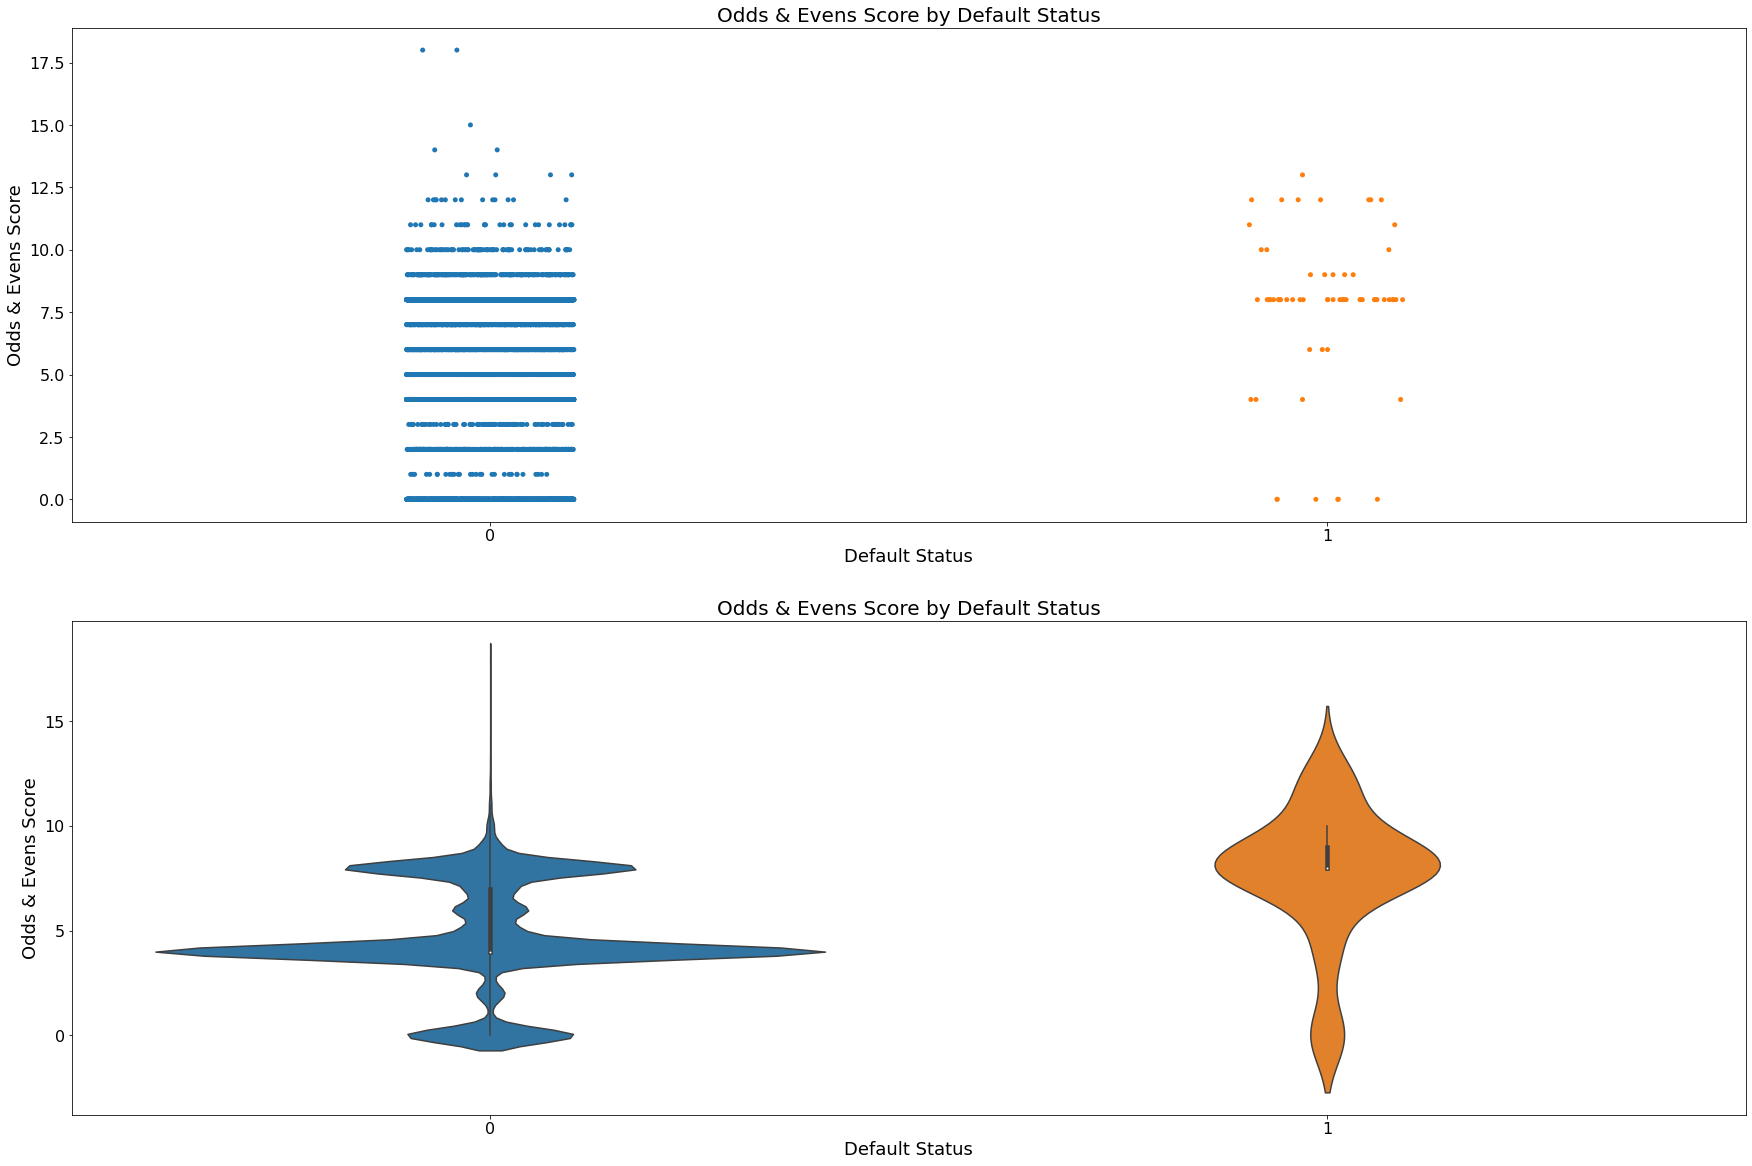

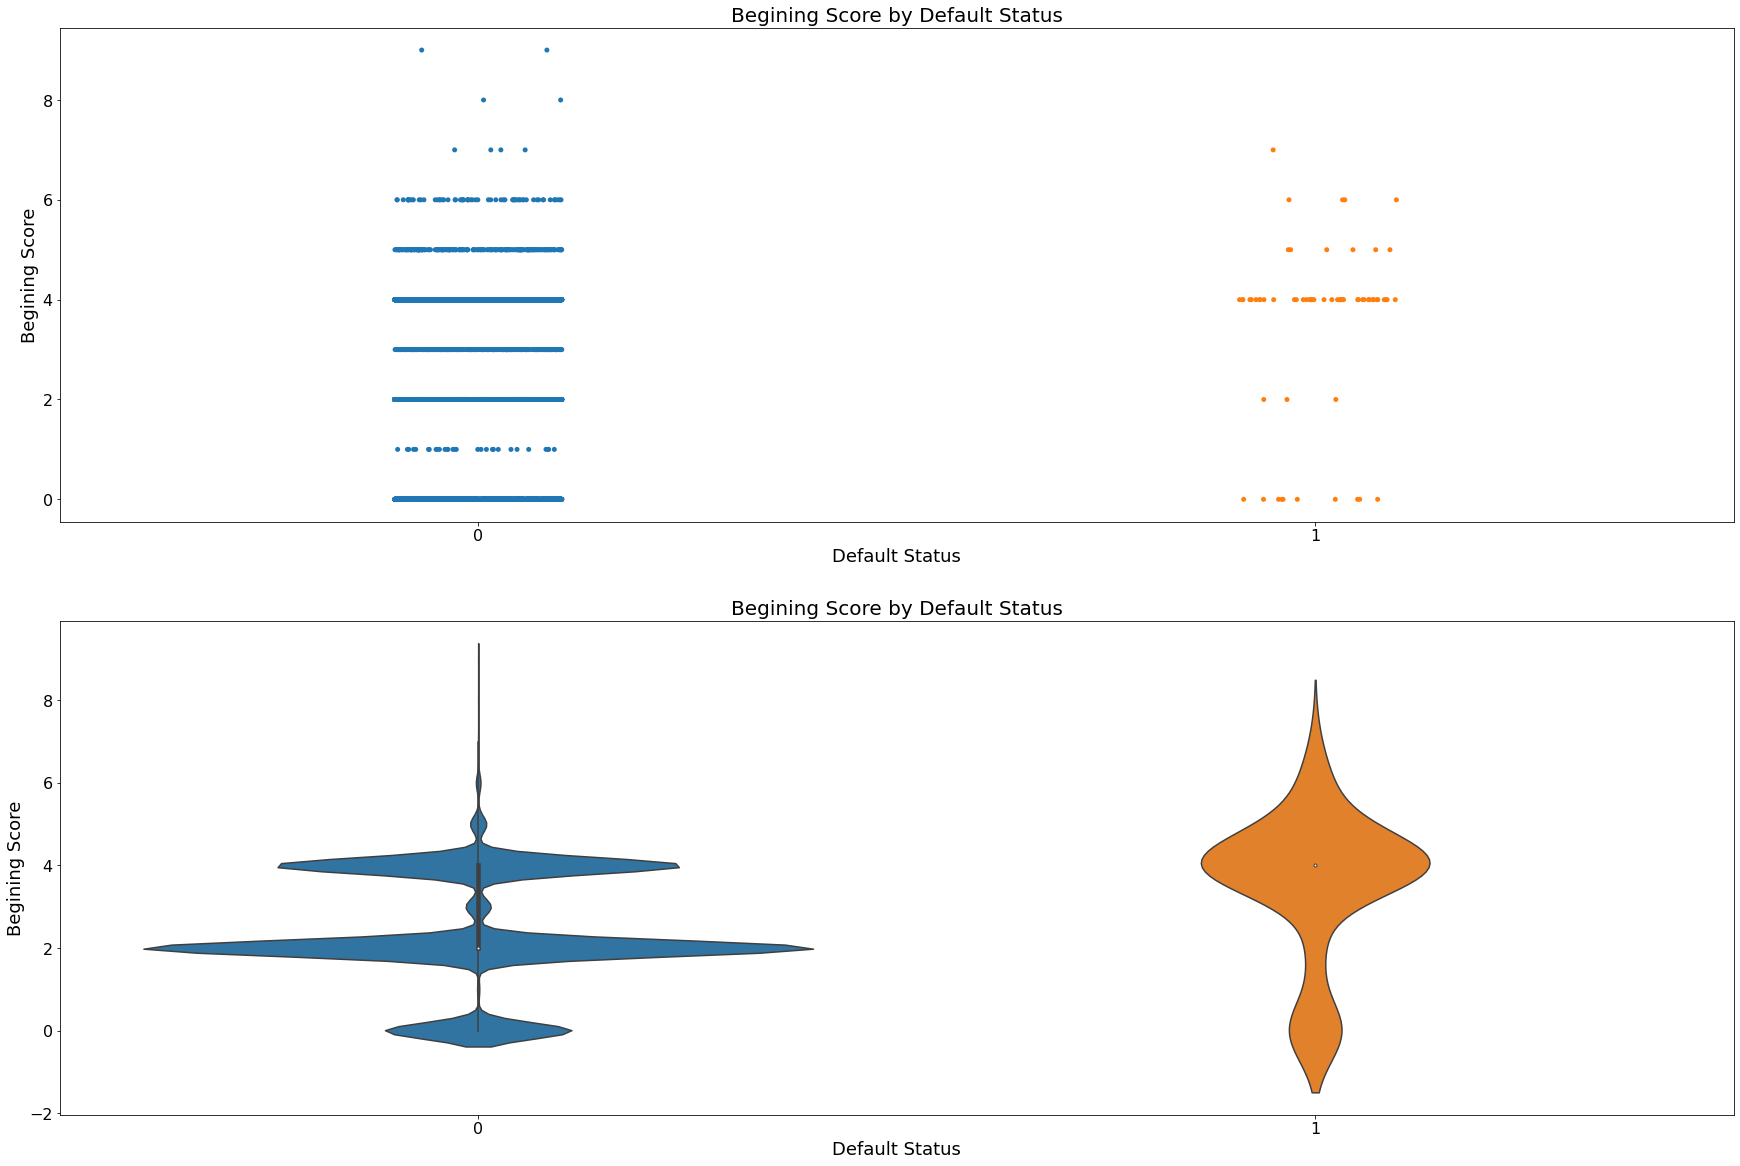

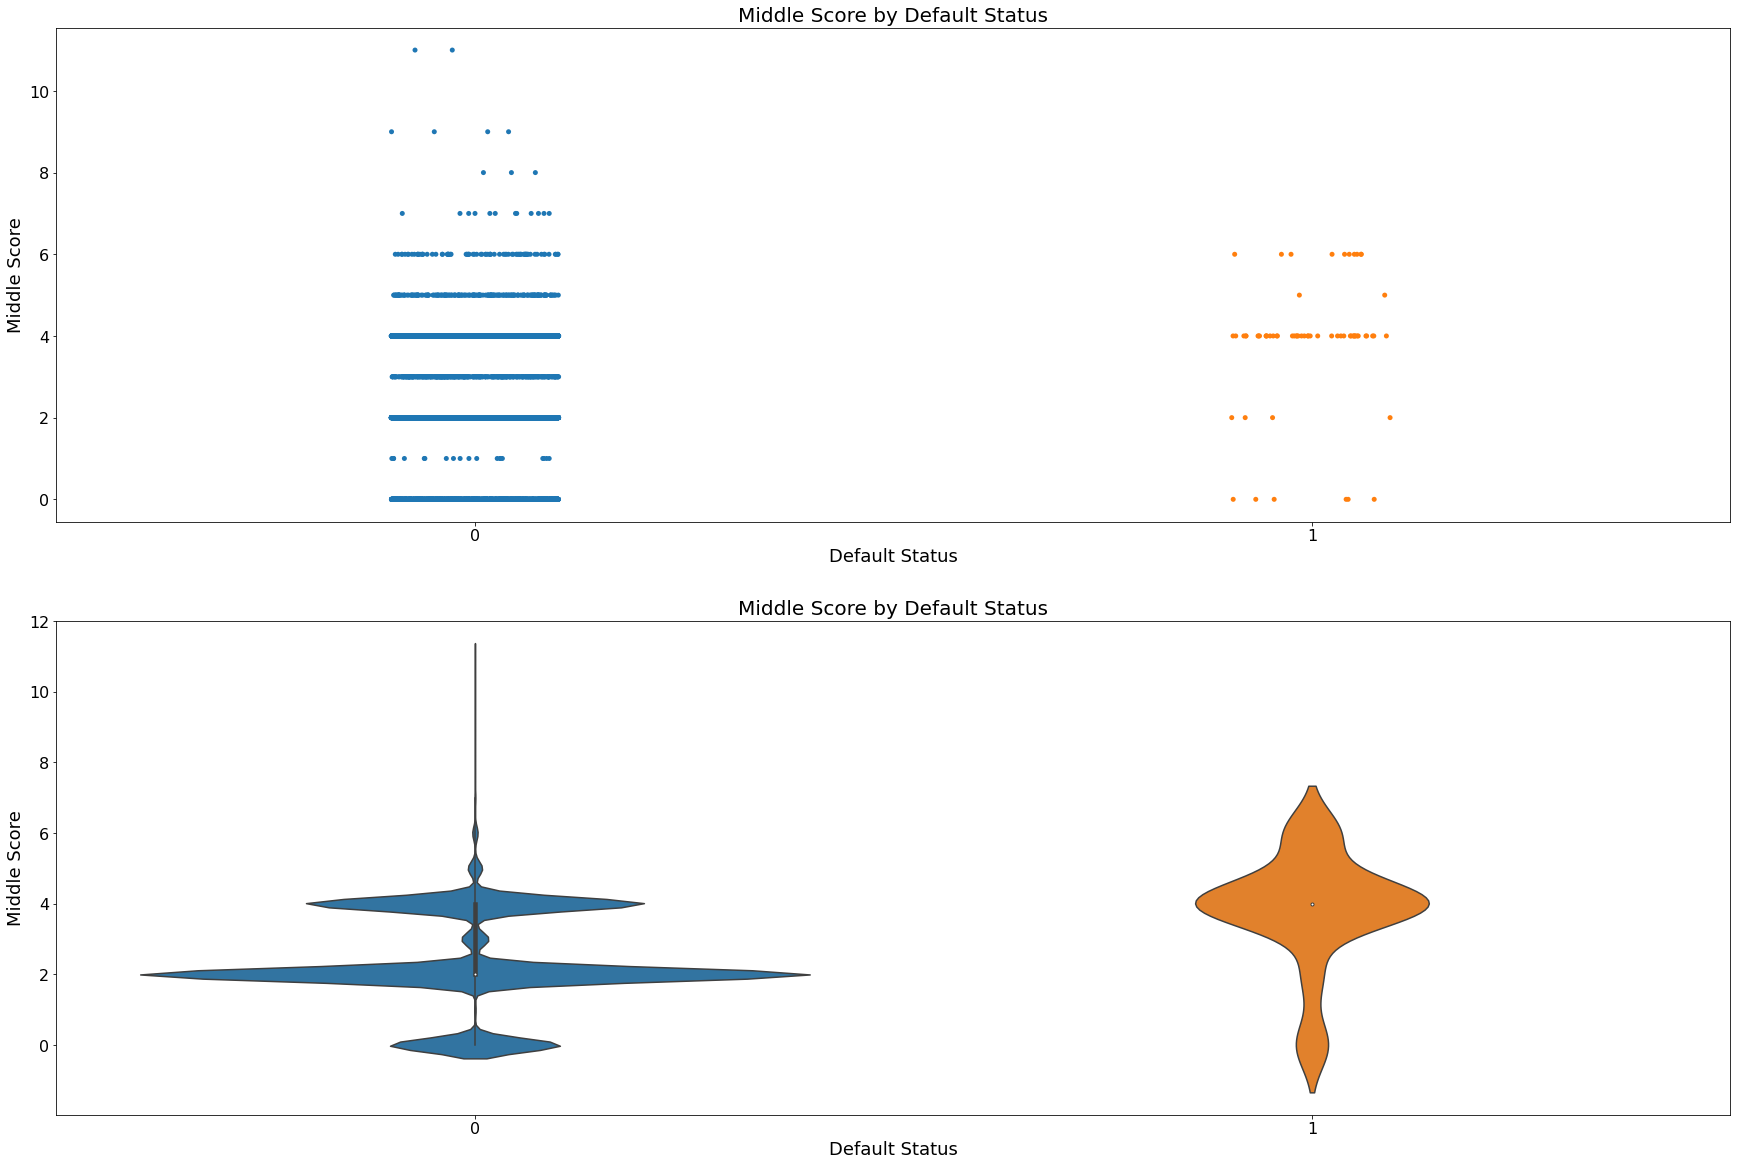

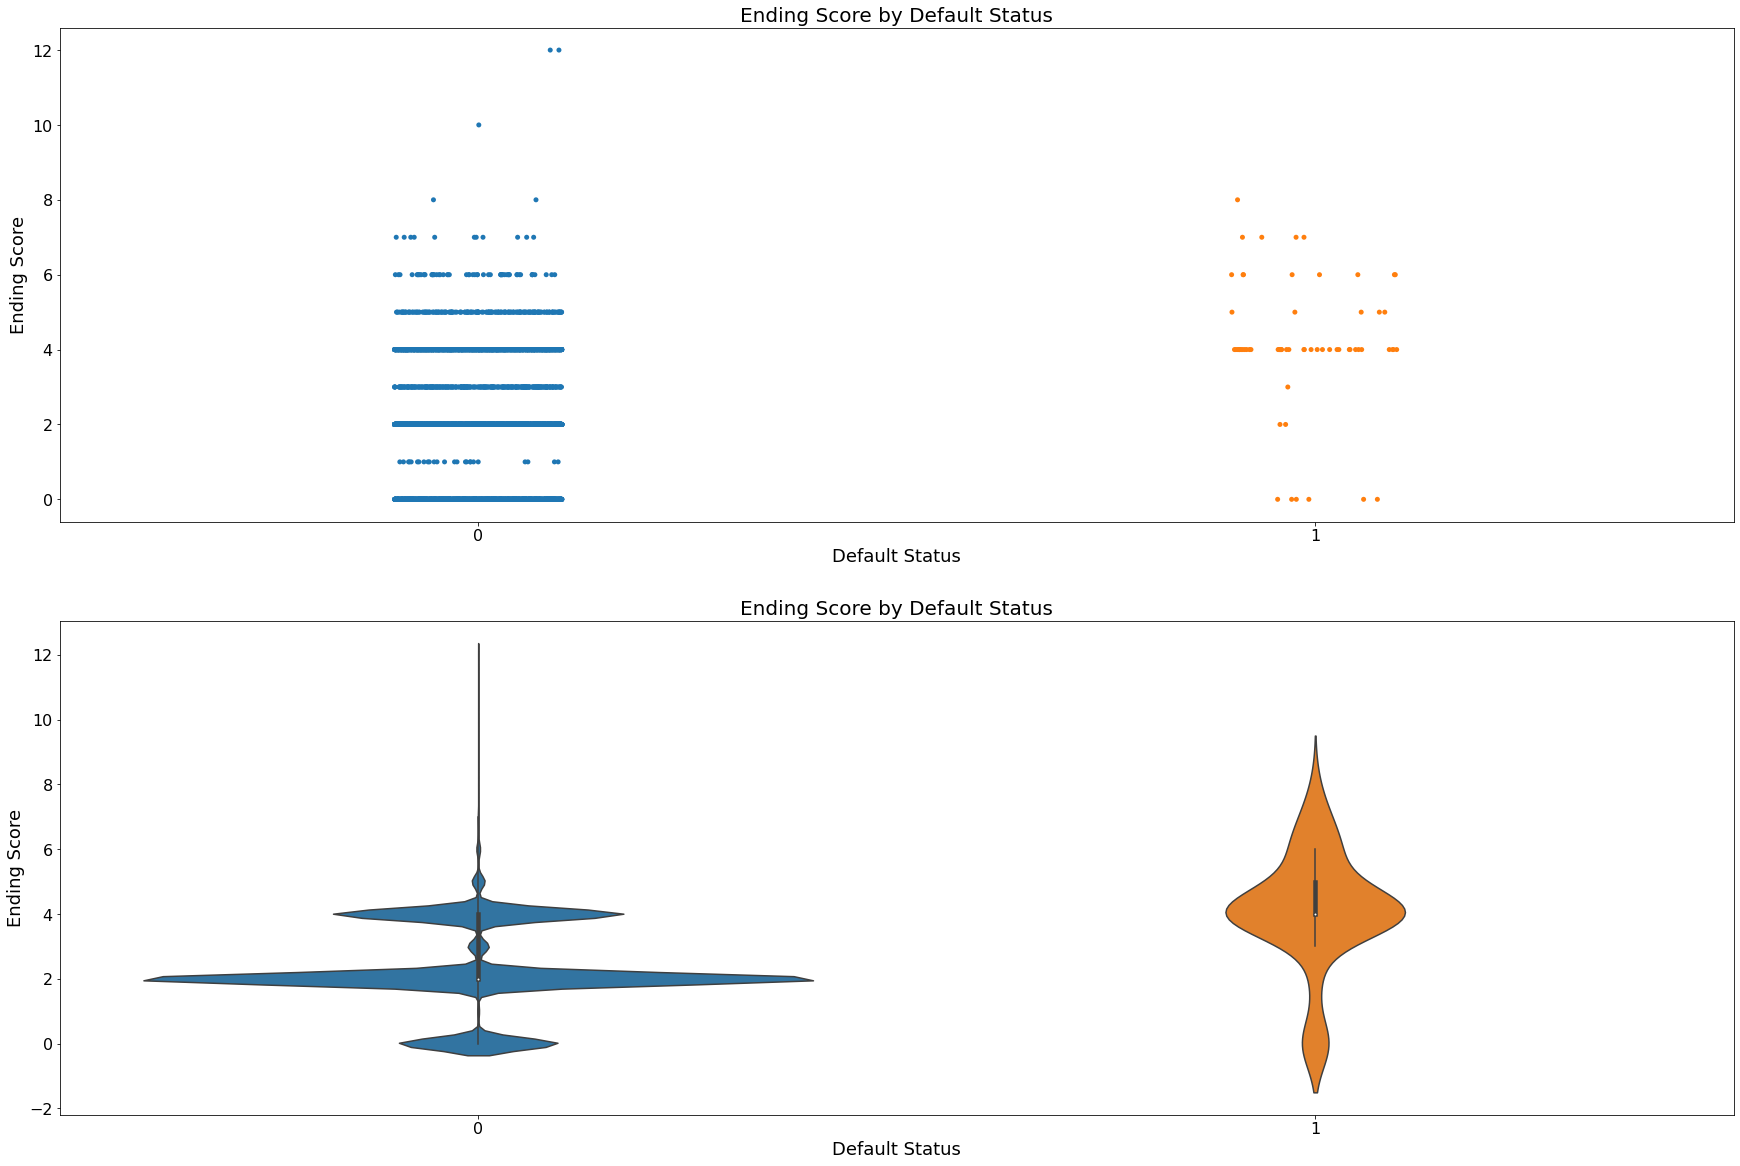

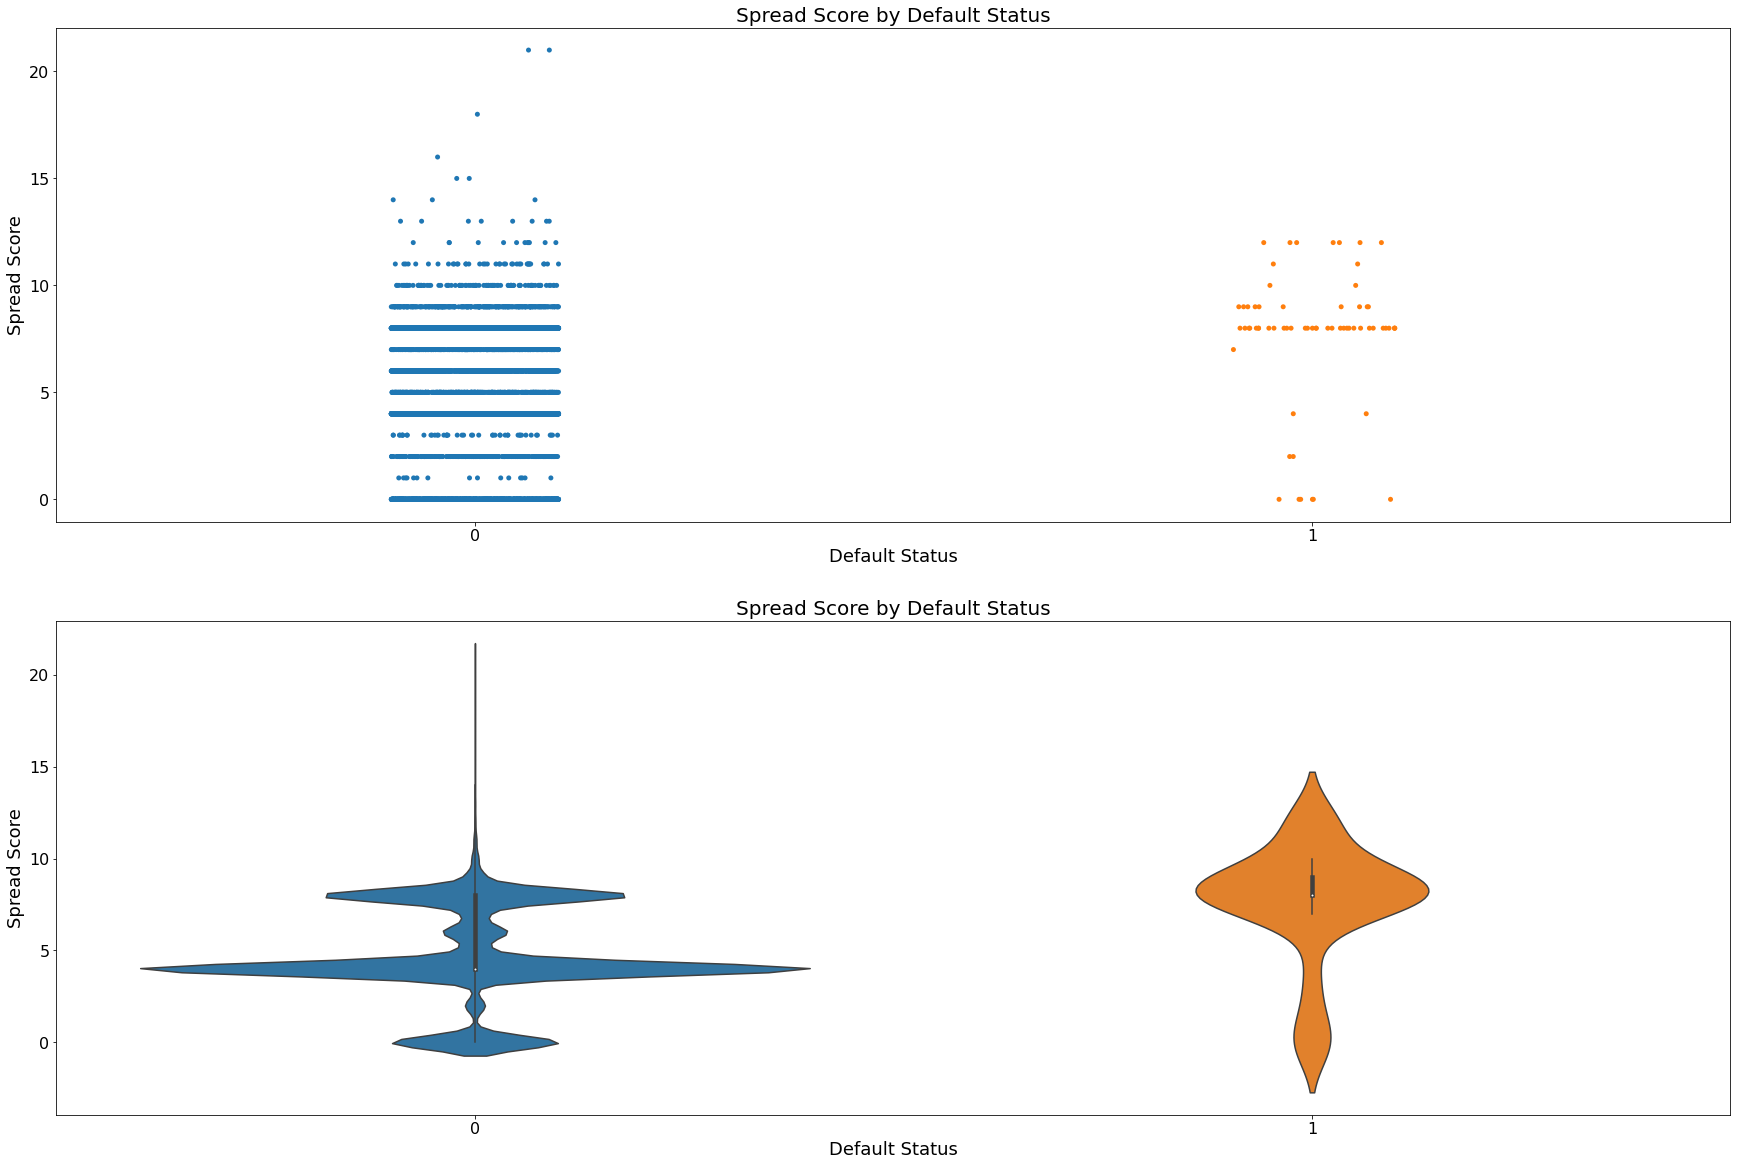

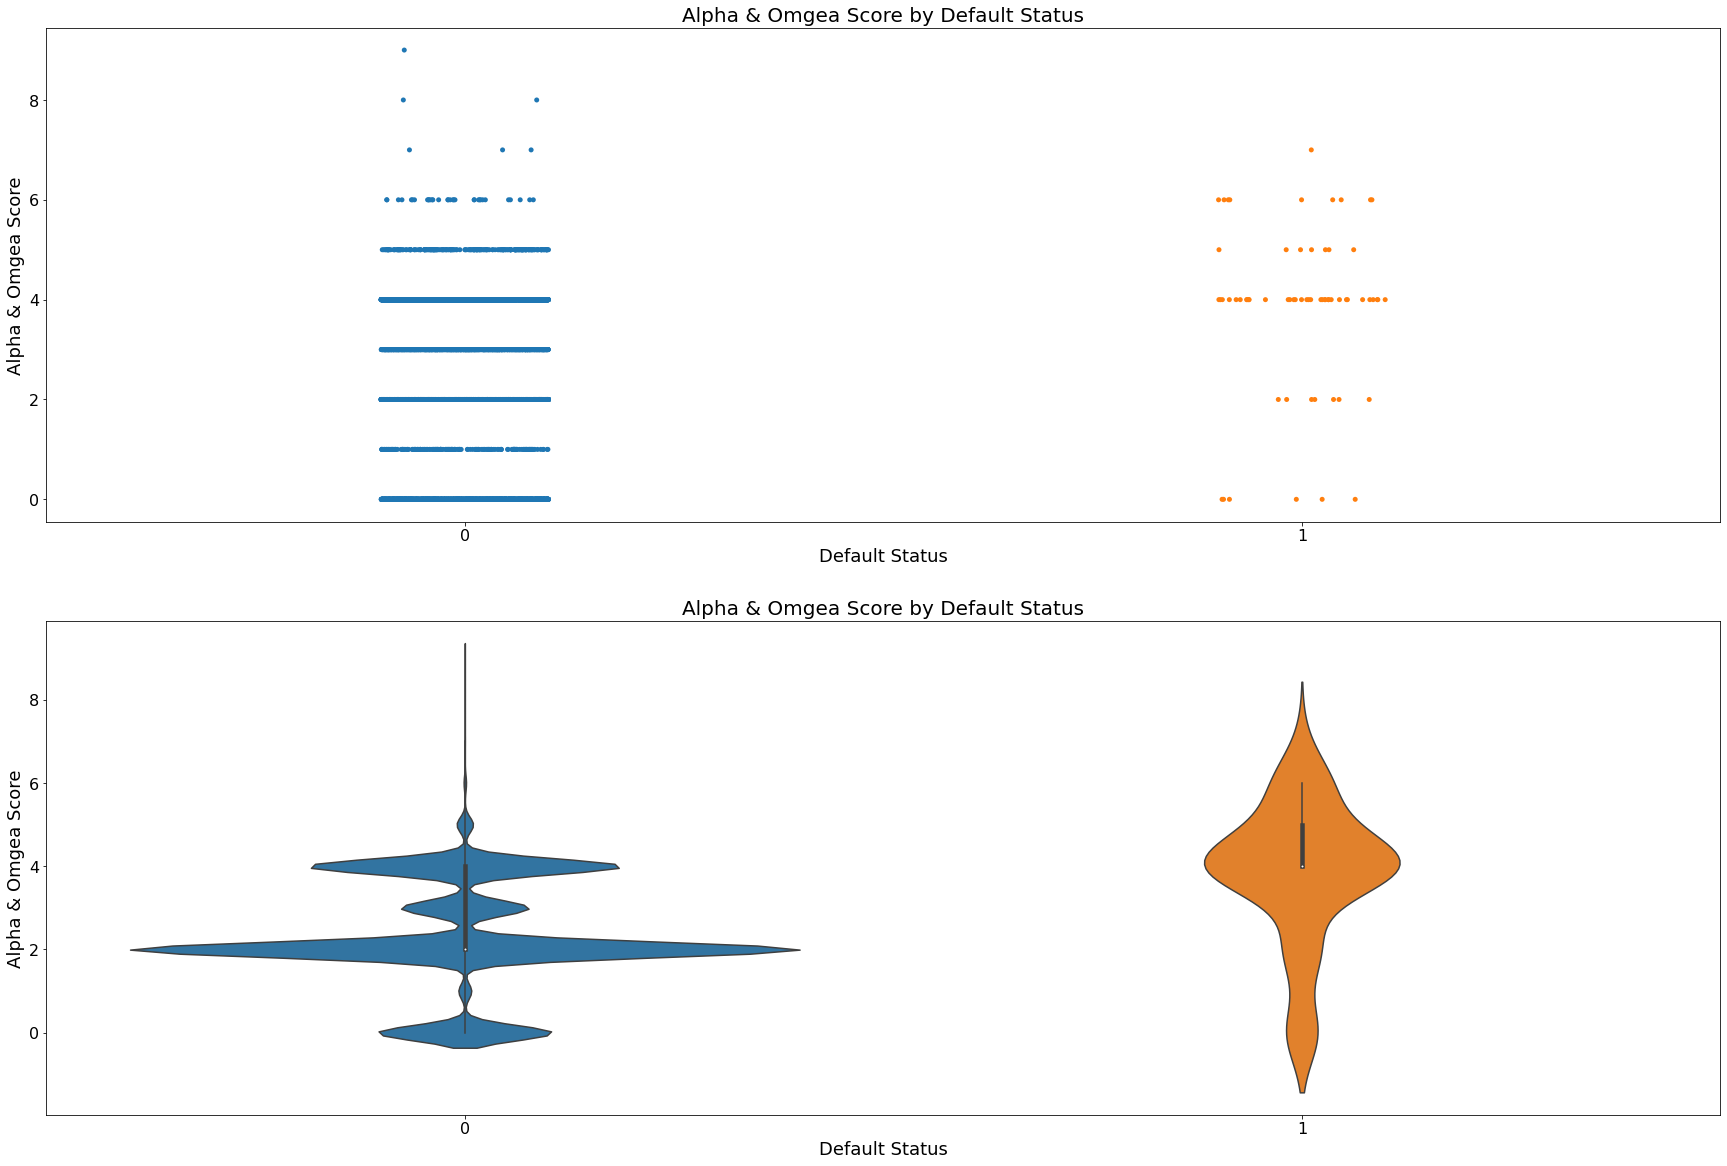

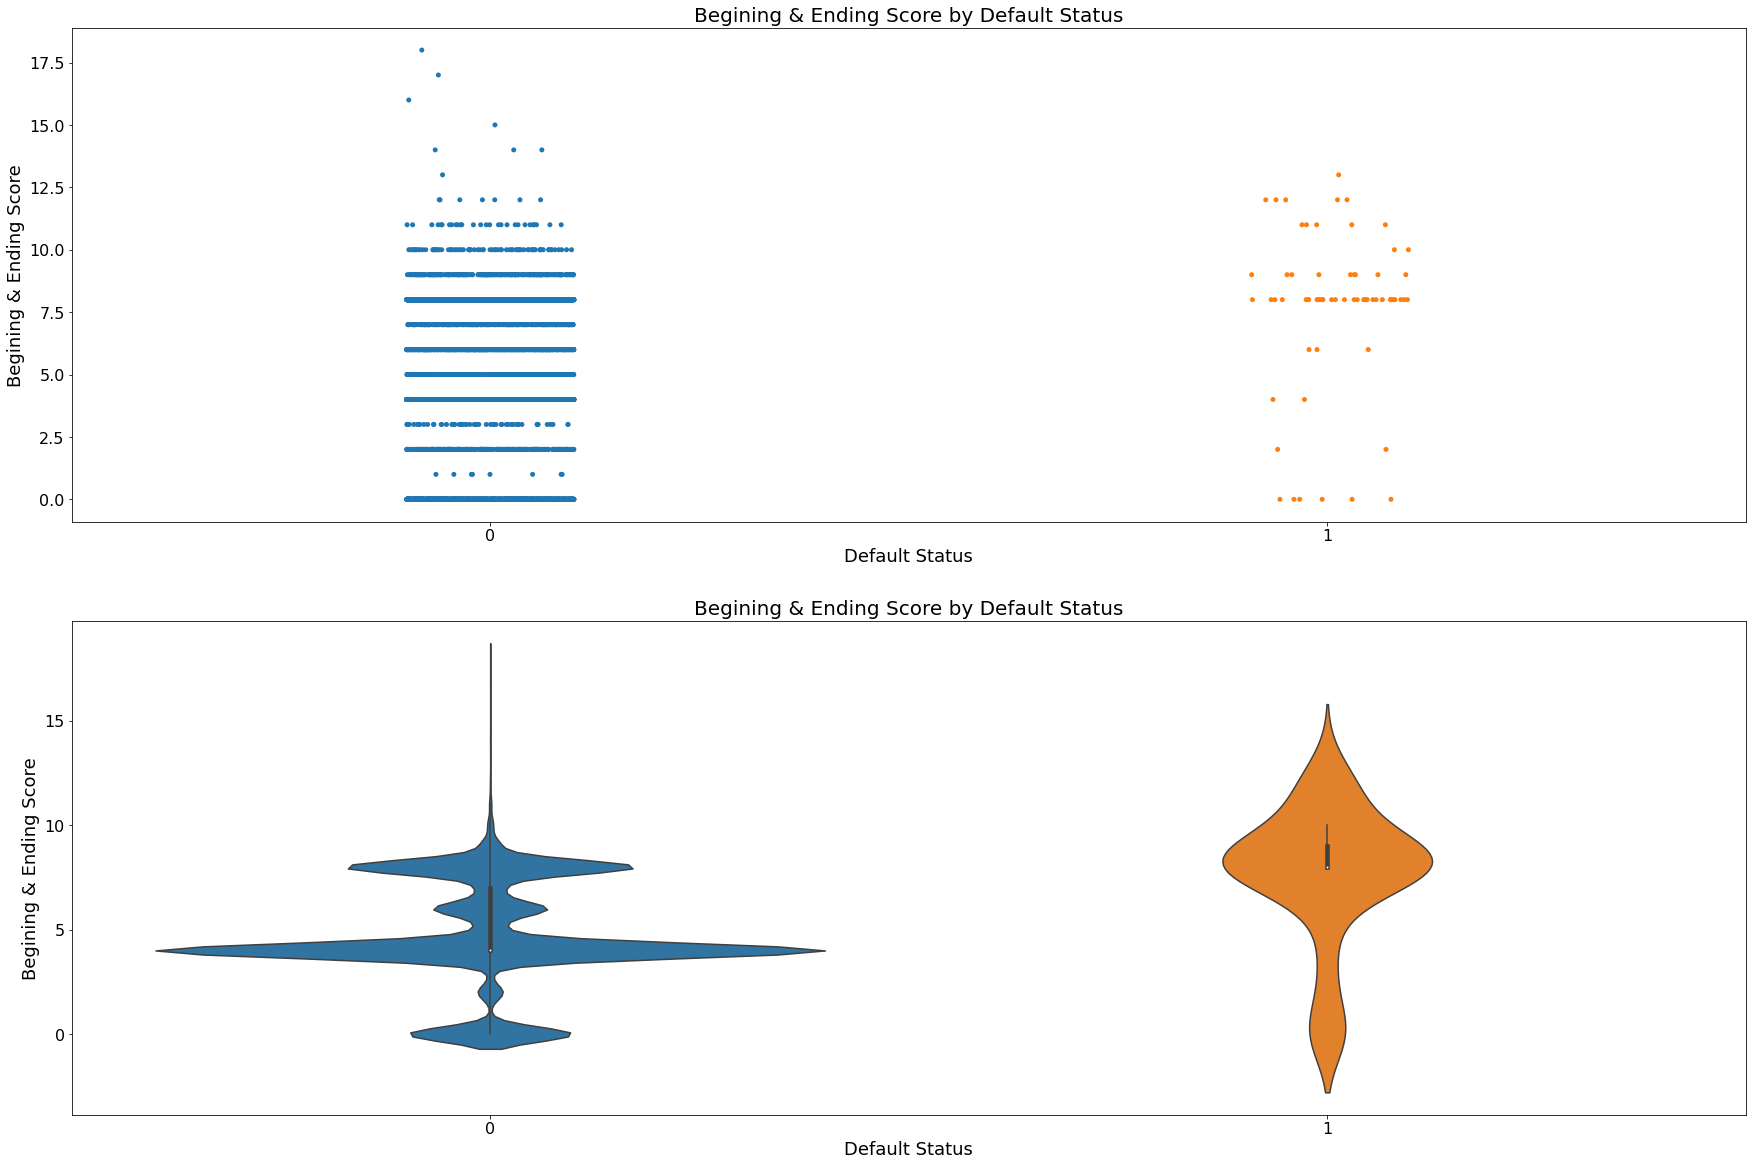

In [22]:
# Plot striplot (swarm plot wouldn't work) and violin plot pairs for all continious variables
columns = ['total_score', 'odd_months_score', 'last_half_score',
       'first_half_score', 'difference_score', 'odds_evens_score',
       'begining_score', 'middle_score', 'ending_score', 'spread_score',
       'alpha_omgea_score', 'begining_ending_score']
# create a label list for xtics
labels = ['Total Score', 'Odd Months Score', 'Last Half Score', 'First Half Score', 'Difference Score', 'Odds & Evens Score', 'Begining Score', 'Middle Score', 'Ending Score', 'Spread Score', 'Alpha & Omgea Score', 'Begining & Ending Score']

for col, label in zip(columns, labels):
    plt.figure(figsize=(30,20))
    plt.subplot(211)
    sns.stripplot(data=train, x='defaulted', y=col)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Default Status', fontsize=18)
    plt.ylabel(label, fontsize=18)
    plt.title(f'{label} by Default Status', fontsize=20)
    plt.subplot(212)
    sns.violinplot(data=train, x='defaulted', y=col)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Default Status', fontsize=18)
    plt.ylabel(label, fontsize=18)
    plt.title(f'{label} by Default Status', fontsize=20)

### Insightful Visualizations

***This section is included to highlight useful visualizations with a quick link***

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

## Hypothesis Testing

***summarize findings here***

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Modeling

***Explain the models created here***

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Results and Conclusions

***Explain the results from modeling minus the test here**

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [23]:
# Cell for running test model

***how did the model perform on test***

## Next Steps

***Next steps here***


---


**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Appendix


---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)